# [E-08] 뉴스 요약봇 만들기

## 라이브러리 불러오기

In [1]:
import nltk#nltk = Natural Language Toolkit의 축약어로 영어기호, 통계, 자연어 처리를 위한 라이브러리
nltk.download('stopwords')# i, my, me, over,조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는데는 거의 의미가 없는 100여개의 불용어가 정리되어있다

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1) 데이터 수집하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- headlines열을 요약으로 보고 text열을 본문으로 본다

In [3]:
data.sample(10)

,headlines,text
1662,Give security to 2 women who entered Sabarimal...,The Supreme Court on Friday directed the Keral...
80392,Veteran tennis players play 61-shot rally at W...,Veteran tennis players including Mansour Bahra...
92785,US mulls shooting down North Korean missile te...,The US is considering shooting down future Nor...
22798,24 girls rescued from UP shelter home after 1 ...,"At least 24 girls were rescued, while 18 are m..."
79267,India wins 2 high jump medals at World Para At...,India's para athletes Sharad Kumar and Varun S...
63273,Ranaut's pics as Rani Laxmibai from film sets ...,Actress Kangana Ranaut's pictures as Rani Laxm...
89144,Why is India not attending China's Belt and Ro...,India is set to skip China's two-day Belt and ...
81767,Julianne Moore becomes face of lingerie brand ...,Oscar-winning actress Julianne Moore has becom...
24363,Pak's Imran Khan listens to 1992 WC song in ca...,Pakistani cricketer-turned-politician Imran Kh...
43251,Microsoft offers Ã¢ÂÂ¹1.6 crore to identify c...,Technology giant Microsoft has offered about Ã...


In [4]:
print("문장 전체 수 :", len(data))

문장 전체 수 : 98401


## 2) 데이터 전처리하기(추상적 요약)

### 중복 문장과 NULL 값이 존재하는 문장 제거

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


문장은 총 98401개였지만 중복을 배제한 수는 98360개로 41개가 중복인 것을 알 수 있다.

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('중복을 제거한 문장 전체 수 :', (len(data)))

중복을 제거한 문장 전체 수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 문장수 :', (len(data)))

전체 문장수 : 98360


### 텍스트 정규화와 불용어 제거

정규화 사전 (출처: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

EX)

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


원래 값에서 전처리 한 결과 값으로 빈 값들을 NULL값으로 대체 

In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

현재 NULL값은 없지만 있는 경우에 대비하여 Null값 제거

In [16]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 문장의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


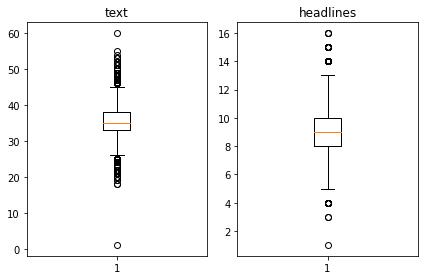

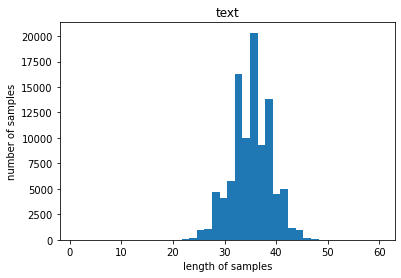

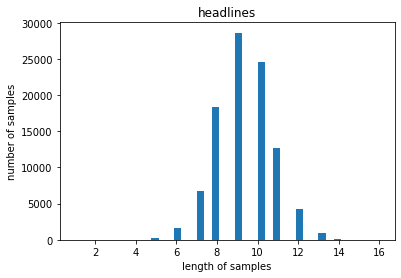

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- text의 경우 최소 길이: 1, 최대 길이: 60, 평균 길이: 35
- headlines은 최소 길이: 1, 최대 길이: 16, 평균 길이: 9
- text는 길이가 30-40에서 많은 분포를 이루고, headlines은 8-10에서 많은 분포를 이룬다

### 길이의 차이들이 심하게 나지 않아 이 각 최대길이로 가는 것으로 결정

In [19]:
text_max_len = 60
headlines_max_len = 16

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 시작 토큰과 종료 토큰 추가하기

- 시작 토큰은 sostoken
- 종료 토큰은 eostoken

In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [24]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터 분리

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[25384 67772 15592 ... 26181 55186  3183]


In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 단어 집합 만들기 및 정수 인코딩

In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69667
등장 빈도가 6번 이하인 희귀 단어의 수: 47510
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22157
단어 집합에서 희귀 단어의 비율: 68.19584595289018
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.489832621424328


- 등장 빈도가 6이하인 단어들은 정수 인코딩 과정에서 빼고 훈련 데이터에서 제거
- 이를 제외한 단어 집합의 크기는 22,159 이와 비슷한 값으로 어림잡아 단어 집합 크기를 20,000으로 설정

In [31]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[419, 159, 163, 56, 52, 10721, 1772, 43, 3527, 193, 57, 4889, 450, 112, 630, 2038, 1876, 1678, 85, 159, 13790, 957, 9140, 2909, 456, 5691, 9, 743, 193, 1396, 159, 289], [2, 857, 46, 913, 632, 9313, 404, 12, 1444, 314, 3986, 2116, 1088, 1061, 9682, 193, 212, 17527, 4754, 46, 365, 14, 774, 260, 812, 360, 2347, 80, 130, 3913, 98, 363, 2347, 10276, 332, 393, 2827, 46, 530], [3180, 1282, 156, 15983, 1282, 3394, 358, 780, 1411, 127, 2828, 698, 2711, 2602, 15983, 1, 2043, 3180, 780, 1411, 153, 915, 12220, 1665, 223, 502, 4520, 34, 12220, 34, 6976, 15983, 1]]


In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30084
등장 빈도가 5번 이하인 희귀 단어의 수: 19658
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10426
단어 집합에서 희귀 단어의 비율: 65.34370429464167
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.643595474572843


- 등장 빈도가 5이하인 단어들은 정수 인코딩 과정에서 빼고 훈련 데이터에서 제거
- 이를 제외한 단어 집합의 크기는 10,407 이와 비슷한 값으로 어림잡아 단어 집합 크기를 10,000으로 설정

In [35]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 357, 130, 9483, 1139, 51, 2232, 3, 7230, 540, 102], [1, 55, 601, 6, 5188, 716, 7, 1355, 145, 3412, 8], [1, 5189, 787, 826, 1979, 11, 3251, 729, 6, 72], [1, 20, 910, 2209, 3, 121, 3111, 717], [1, 5899, 9, 18, 457, 4, 50, 2862, 18, 1036, 378, 46, 2804]]
target
decoder  [[357, 130, 9483, 1139, 51, 2232, 3, 7230, 540, 102, 2], [55, 601, 6, 5188, 716, 7, 1355, 145, 3412, 8, 2], [5189, 787, 826, 1979, 11, 3251, 729, 6, 72, 2], [20, 910, 2209, 3, 121, 3111, 717, 2], [5899, 9, 18, 457, 4, 50, 2862, 18, 1036, 378, 46, 2804, 2]]


### 훈련 데이터와 테스트 데이터에 대해서 길이가 1인 문장 삭제 
- 길이가 1인 이유는 sostoken과 eostoken이 남아 있기 때문

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 패딩하기

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 3) 어텐션 메커니즘 사용하기(추상적 요약)

## 모델 설계

### 함수형 API 이용하여 인코더 설계

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸린다.

- hidden state는 LSTM에서 얼만큼의 수용력을 가질지를 정하는 파라미터(무조건 용량을 많이준다고 성능이 올라가는 것은 아니다)
- 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합을 해결해주는 방법
- recurrent dropout은 dropout을 레이어가 아닌 time stem 마다 해주는 방식 time step의 입력을 랜덤으로 생략
- recurrent dropout은 일반적인 dropout과 같이 regularization을 해주는 효과와 과적합을 방지해준다.

### 디코더 설계

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### 어텐션 메커니즘

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 모델 훈련

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)# EarlyStopping특정 조건이 충족되면 훈련을 멈추는 역할 
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 272s 852ms/step - loss: 4.2820 - val_loss: 3.8985
Epoch 2/50
308/308 [==============================] - 260s 845ms/step - loss: 3.7925 - val_loss: 3.6272
Epoch 3/50
308/308 [==============================] - 259s 841ms/step - loss: 3.5447 - val_loss: 3.4298
Epoch 4/50
308/308 [==============================] - 256s 830ms/step - loss: 3.3477 - val_loss: 3.2888
Epoch 5/50
308/308 [==============================] - 257s 834ms/step - loss: 3.1924 - val_loss: 3.1934
Epoch 6/50
308/308 [==============================] - 250s 812ms/step - loss: 3.0622 - val_loss: 3.0954
Epoch 7/50
308/308 [==============================] - 259s 842ms/step - loss: 2.9541 - val_loss: 3.0246
Epoch 8/50
308/308 [==============================] - 257s 836ms/step - loss: 2.8622 - val_loss: 2.9803
Epoch 9/50
308/308 [==============================] - 250s 811ms/step - loss: 2.7812 - val_loss: 2.9358
Epoch 10/50
308/308 [==============================] - 253s 822m

- EarlyStopping(monitor='val_loss', patience=2, verbose=1)
- val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2)관측되면 학습 stop

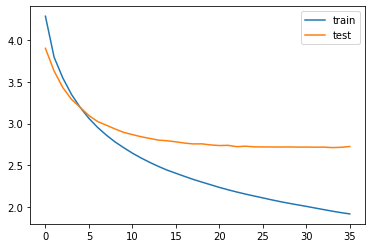

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- val_loss 값이 감소하는 중에 높아진 적이 있지만, 이 현상은 카운트 하지 않고 연속으로 증가하는 현상이 일어나면은 stop하는 것 같다.
- train loss 값은 계속 감소하는 추세를 보이지만 test loss 값은 감소하는 와중 2.7에서 증가 감소가 계속 이루어진 것을 볼 수 있었다.

## 인퍼런스 모델 구현하기

- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야함

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- 인코더와 디코더 모델을 분리해서 설계

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

- 어텐션 메커니즘을 사용하는 출력층 설계

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

- 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [52]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4) 실제 결과와 요약문 비교하기 (추상적 요약)

## 모델테스트

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### 약 50개의 샘플에 대한 실제 요약과 예측 요약

In [54]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : punjab cm captain amarinder singh announced free education girls government schools colleges state nursery phd fulfilling poll promise cm also announced five new colleges state current fiscal year free textbooks provided government schools besides free nursery classes next academic session onwards 
실제 요약 : free education for girls up to phd in punjab govt colleges 
예측 요약 :  punjab cm to take school education without students


원문 : paris based historian claimed found french secret service report december suggests netaji subhash chandra bose alive time report claimed bose whereabouts unknown time refuting indian government claim passed away two years ago august 
실제 요약 : netaji was alive in french secret service report 
예측 요약 :  japan to launch digital tag for killing


원문 : pakistan supreme court verdict panama papers scandal thursday began quote mario novel godfather behind every great fortune crime court said noting novel violent tale mafia family court called probe allegations p

예측 요약 :  rbi asks banks to remain rbi on bank of fy


원문 : residents us city maine witnessing ice disk phenomenon measuring metres across freezing river water flows slowly main current likely freeze creating disc spin melt melting water spins scientists said 
실제 요약 : metre wide ice surfaces in us river 
예측 요약 :  us researchers find water bottle of the beach


원문 : hospital australia pays poop donors year delivering poop five times week donors must healthy weight need take blood test determine eligibility poop transplants used help treat medical conditions like autism chronic diarrhoea 
실제 요약 : australian hospital pays over lakh year for poop 
예측 요약 :  aus restaurant turns showstopper for stomach


원문 : us based startup offers cancer diagnosis using full body mri raised million seed round led vc firm accomplice round saw participation investors including founders future ventures number angel investors founded uses artificial intelligence assist doctors detecting cancer mri scans 
실제 요약 

예측 요약 :  west bengal govt to give sanitary napkins to west bengal


원문 : first us based researchers created mimicking material may allow surgeons print knee replacement parts based material matching human strength tested stability plastic model knee custom implants based models patient obtained ct mri scans scientists said 
실제 요약 : like made for knee implants 
예측 요약 :  scientists create first ever human hair


원문 : trailer indian upcoming documentary nobel laureate amartya sen released comes censor board stalled film release use words cow gujarat hindutva view india hindu india among others documentary directed suman ghosh 
실제 요약 : trailer of film on nobel laureate sen released 
예측 요약 :  trailer of indian film released on the released


원문 : external affairs minister sushma swaraj granted medical visas ailing pakistani man requiring liver transplant three year old girl country needs open heart surgery august year swaraj tweeted auspicious occasion india independence day grant medical v

## 5) Summa을 이용해서 추출적 요약해보기

#### Summa 설치
$ pip list | grep summa

## 데이터 다운로드

In [55]:
import requests
from summa.summarizer import summarize

In [58]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
Edata = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [61]:
Edata.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [68]:
Edata['text'].iloc[1]

"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."

#### summarize() 인자:
- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [79]:
print('Summary:')
print(summarize(Edata['text'].apply(str).iloc[1], ratio=0.3))

Summary:



In [82]:
print('Summary:')
print(summarize(Edata['text'].apply(str).iloc[1], ratio=0.7))

Summary:
Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


- ratio 값이 0.4미만으로는 요약이 나오질 않는다 값이 나온는 0.4로 ratio 값을 설정

In [80]:
print('Summary:')
print(summarize(Edata['text'].apply(str).iloc[1], ratio=0.4))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [87]:
def Extractive():
    for i in range(50, 100):
        print("원문 :",Edata['text'].apply(str).iloc[i], '\n' )
        print("예측 요약 :", summarize(Edata['text'].apply(str).iloc[i], ratio=0.4))
        print("\n")

In [88]:
Extractive()

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets. 

예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018.  

예측 요약 : Boeing retained its 

예측 요약 : Yami Gautam was felicitated by Border Security Force (BSF) in Amritsar for her performance in 'Uri: The Surgical Strike'.


원문 : Social media giant Facebook has hired privacy critic Nate Cardozo, formerly the top legal counsel for US privacy watchdog EFF, as a privacy policy manager for WhatsApp. Cardozo had called Facebook a "faceless corporation" whose business model depends on user's confusion and indifference about privacy, in October 2015. Facebook has also hired attorney Robyn Greene as its privacy policy manager. 

예측 요약 : 


원문 : Apple CEO Tim Cook said the company plans to lower some iPhones' prices in markets with currencies that weakened against the US dollar in the past year. "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added. The price cuts, in hopes of increasing sales, are reportedly occurring for second time in 12 years. 

예측 요약 : "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate wi

원문 : Venezuelan President NicolÃÂ¡s Maduro has claimed that his American counterpart Donald Trump ordered the Colombian government and the Colombian mafia to kill him. "If something happens to me, Trump and Colombian President IvÃÂ¡n MÃÂ¡rquez will bear responsibility," he added. The US has blamed Maduro for the economic crisis in Venezuela and recognised opposition leader Juan GuaidÃÂ³ as interim President. 

예측 요약 : Venezuelan President NicolÃÂ¡s Maduro has claimed that his American counterpart Donald Trump ordered the Colombian government and the Colombian mafia to kill him.


원문 : Eight Asian billionaires aged 90 or above on the Bloomberg Billionaires Index of world's 500 richest people have a combined net worth of $125 billion. The richest among them is Hong Kong's Li Ka Shing with a net worth of $30.5 billion. India's 90-year-old Pallonji Mistry, who controls 18.3% of Tata Sons through Shapoorji Pallonji Group, is worth $20.1 billion. 

예측 요약 : The richest among them is Hong

## 회고

#### 추상적 요약 문제점
- 실제 요약과 내가 예측한 요약을 비교했을 때 비슷한 것도 있었지만 다른 내용을 가진 것도 있었다. 
- 단어하나를 아예 줄인 경우도 있었다 (ex: pakistan을 pak으로) 이런 경우라면 요약을 한 것을 읽었을 때 의미 해석이 어려울 것 같다
- 모델을 학습하는데에 너무 많은 시간이 걸렸다. EarlyStopping을 썻지만 언제 멈출줄 모르는 기다림이 있었다.

#### 추출적 요약 문제점
- 추상적 요약에 비해 핵심단어나 문장 내용이 많이 담겨있지만, 문장길이가 길어 가독성이 힘든 것 같다.
- ratio의 값이 0.4 밑으로는 출력이 안되는 이유를 찾지 못했다.
- 특수문자나 가로 같은 경우도 같이 포함되어 요약의 정체성이 부족하다.